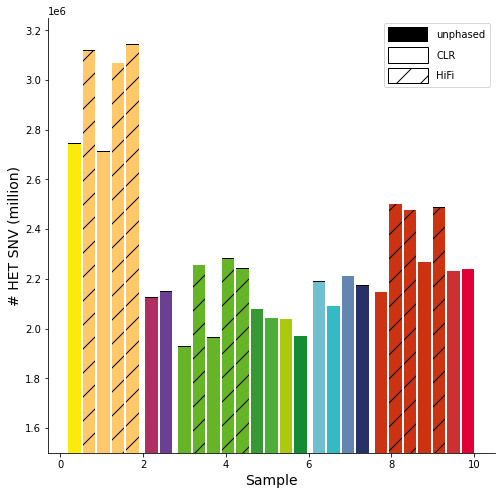

In [1]:
import os
import csv
import collections
import importlib

import numpy as np
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.patches as patches

plot_aux_module = '/home/local/work/code/github/project-diploid-assembly/notebooks/aux_mods/plot_aux.py'
plot_aux_spec = importlib.util.spec_from_file_location("plot_aux", plot_aux_module)
plot_aux = importlib.util.module_from_spec(plot_aux_spec)
plot_aux_spec.loader.exec_module(plot_aux)

samples = plot_aux.load_sample_table()
hexcodes, rgbcodes, popmap = plot_aux.load_population_annotation()

stats_path = '/home/local/work/data/hgsvc/wh_phasing_stats'
out_path = os.path.join(stats_path, 'phasing_stats_panel.png')
cache_file = os.path.join(stats_path, 'cache.h5')


def load_phasing_stats(file_path):
    stats = dict()
    with open(file_path, 'r', newline='') as table:
        rows = csv.DictReader(table, delimiter='\t')
        for row in rows:
            if row['chromosome'] != 'ALL':
                continue
            het_var = int(row['heterozygous_variants'])
            het_snv = int(row['heterozygous_snvs'])
            phased_snv = int(row['phased_snvs'])
            assert het_var == het_snv, 'shit'
            stats['het_snv'] = het_snv
            stats['phased'] = phased_snv
            stats['phased_pct'] = round(phased_snv/het_snv * 100, 1)
    return stats


if not os.path.isfile(cache_file):
    stat_files = [os.path.join(stats_path, f) for f in os.listdir(stats_path) if f.endswith('.wh-phased.stats.tsv')]
    plot_data = [load_phasing_stats(fp) for fp in stat_files]

    sample_platform = [plot_aux.extract_sample_platform(os.path.basename(f)) for f in stat_files]
    row_index = []
    for sample, platform in sample_platform:
        super_pop = samples[sample]['super_population']
        pop = samples[sample]['population']
        row_index.append((sample, super_pop, pop, platform))
    df = pd.DataFrame(plot_data, columns=['het_snv', 'phased', 'phased_pct'], index=row_index)
    df.index = pd.MultiIndex.from_tuples(df.index.values, names=['sample', 'super_pop', 'pop', 'platform'])
    df.to_hdf(cache_file, key='cache', mode='w', format='fixed')
    
df = pd.read_hdf(cache_file, 'cache')
df.sort_index(axis=0, inplace=True, level=['sample', 'super_pop', 'pop', 'platform'])

def plot_phasing_statistic(sample_stats):
    
    bar_width = 0.3

    fig, axis = plt.subplots(figsize=(8,8))
    
    value_collector = collections.defaultdict(list)
    x_pos_counter = 0
    
    for sp in plot_aux.get_population_sorting():
        try:
            subset = sample_stats.xs(sp, level=1, drop_level=False)
        except KeyError:
            continue
        for index, row in subset.iterrows():
            color = rgbcodes[index[2]]
            phased = int(row['phased'])
            unphased = int(row['het_snv']) - phased            
            x_pos_counter += 0.35

            value_collector[(index[3], 'unphased')].append(unphased)
            value_collector[(index[3], 'phased')].append(phased)
            value_collector[(index[3], 'colors')].append(color)
            value_collector[(index[3], 'x_pos')].append(x_pos_counter)
        x_pos_counter += 0.1
    
    for platform in ['HiFi', 'CLR']:
        axis.bar(
            value_collector[(platform, 'x_pos')],
            value_collector[(platform, 'phased')],
            bar_width,
            label='Phased',
            color=value_collector[(platform, 'colors')],
            hatch='/' if platform == 'HiFi' else None
        )

        axis.bar(
            value_collector[(platform, 'x_pos')],
            value_collector[(platform, 'unphased')],
            bar_width,
            bottom=value_collector[(platform, 'phased')],
            label='Unphased',
            color='black',
        )
    
    axis.set_xlabel('Sample', fontsize=14)
    axis.set_ylabel('# HET SNV (million)', fontsize=14)
    axis.set_ylim(1.5 * 1e6, 3.25 * 1e6)
    axis.spines['top'].set_visible(False)
    axis.spines['right'].set_visible(False)
    
    # build custom legend
    custom_patches = [
#         patches.Patch(facecolor=rgbcodes['AFR'], edgecolor=None,
#                       label='AFR'),
#         patches.Patch(facecolor=rgbcodes['AMR'], edgecolor=None,
#                       label='AMR'),
#         patches.Patch(facecolor=rgbcodes['EAS'], edgecolor=None,
#                       label='EAS'),
#         patches.Patch(facecolor=rgbcodes['EUR'], edgecolor=None,
#                       label='EUR'),
#         patches.Patch(facecolor=rgbcodes['SAS'], edgecolor=None,
#                       label='SAS'),
#         patches.Patch(facecolor='white', edgecolor=None,
#                       label=''),
        patches.Patch(facecolor='black', edgecolor=None,
                      label='unphased'),
        patches.Patch(facecolor='white', edgecolor='black',
                      label='CLR'),
        patches.Patch(facecolor='white', edgecolor='black',
                      label='HiFi', hatch='/'),
    ]
    
    axis.legend(
        handles=custom_patches,
        loc='best',
        handlelength=4,
        handleheight=2
    )
    
    return fig, []

fig, exart = plot_phasing_statistic(df)


fig.savefig(out_path, dpi=600, bbox_inches='tight', extra_artists=exart)
        
        
    